In [16]:
import cv2
cv2.__version__

'4.5.4'

In [17]:
# import sample data
from skimage.data import cells3d
from skimage import io
from pathlib import Path
#import ndimage

import napari
import vispy.color
import vtk
import tetgen
import scipy
import statistics as st
import pymeshlab
import xlsxwriter

import numpy as np

import cv2 as cv
import matplotlib.pyplot as plt
import SimpleITK as sitk
import meshlib
import pyvista as pv
import meshio

from csbdeep.utils import normalize
from scipy import ndimage as ndi

from skimage import filters
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from vispy.color import Colormap
from IPython.display import display_html

from stardist.models import StarDist2D, Config3D, StarDist3D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

from napari.settings import get_settings

import meshlib.mrmeshpy as mr
import meshlib.mrmeshnumpy as mrn

from vispy.color import Colormap
from IPython.display import display_html

from aicsimageio import AICSImage

from skimage.measure import marching_cubes
#from mayavi import mlab
from scipy.spatial import Delaunay

In [18]:
# Get the AICSImage object
tiff_file='IF_2D_S2_M1.tif'
meta=AICSImage(tiff_file)
#img = io.imread(tiff_file)
#print(img.shape)
img = meta.get_image_data("XYZ", T=0) 
print(img.shape)

(2869, 2867, 3)


### Information about the staining

In [19]:
ch_color=['blue','red','green']
ch_marker=['DAPI','F4/80','CD206']
coord_order='YX'

In [20]:
r_X=meta.physical_pixel_sizes.X
r_Y=meta.physical_pixel_sizes.Y
print([r_X,r_Y])

[0.8122087458177024, 0.8122087458177024]


In [21]:
a=[0,0,1,1]
b=[0,1,0,1]

#### Functions

In [22]:
def non_proc(im_in):
    return im_in.copy()

def ln_trans(im_in):
    val_c = 255.0 / np.log(1.0 + np.max(im_in))
    im_out = (val_c * (np.log(im_in + 1.0))).astype(int)
    return im_out.copy()

def exp_trans(im_in,val_a):
    val_c = 255.0 / ((1.0 + val_a)**np.max(im_in) - 1.0)
    im_out = (val_c*((1.0 + val_a)**im_in - 1.0))
    return im_out.copy()

def gamma_trans(im_in,gamma):
    val_c = 255.0 / (np.max(im_in)**gamma)
    im_out = val_c*(im_in**gamma)
    return im_out.copy()

def hist_slide_inc(im_in,shift_in):
    lim=255-shift_in
    im_out[im_in > lim] = 255
    im_out[im_in <= lim] += shift_in
    return im_out.copy()

def hist_slide_dec(im_in,shift_dec):
    lim=shift_dec
    im_out[im_in < lim] = 0
    im_out[im_in >= lim] -= shift_dec
    return im_out.copy()

def cont_stretch(im_in):
    val_a, val_b = 0.0, 255.0
    val_c, val_d = im_in.min(), im_in.max()
    im_out=((im_in-val_c)*((val_b - val_a)/(val_d-val_c)) + val_a).astype(int)
    return im_out.copy()

def contr_limit(im_in,c_min,c_max):
    alpha = 255.0/(c_max - c_min)
    beta = - c_min * (alpha)
    im_out=(np.clip(alpha*im_in+beta, 0.0, 255.0)).astype(int)
    #print(np.max(im_out))
    return im_out.copy()
    
def histo_equal(im_in):
    h=im_in.shape[1]
    w=im_in.shape[2]
    r=im_in.shape[0]

    tot_pixs=h*w*r

    levels=256

    im_hist = np.zeros((levels))

    for i in range(0,levels):
        im_hist[i] = np.count_nonzero(im_in == i)

    pdf = np.zeros((levels))
    for i in range(0,levels):
        pdf[i] = im_hist[i]/tot_pixs

    cdf = np.zeros((levels))
    cdf[0] = pdf[0]
    for i in range(1, levels):
        cdf[i] = pdf[i] + cdf[i-1]

    im_out=im_in.copy()
        
    for u in range(0,r):
        for j in range(0,h):
            for k in range(0,w):
                im_out[u,j,k] = int(round((levels-1) * cdf[im_in[u,j,k]]))
    return im_out.copy()

## MULTIPLE TRANSFORM

##### [options: non_proc(im_in), ln_trans(im_in), exp_trans(im_in,val_a), gamma_trans(im_in,gamma), hist_slide_inc(im_in,shift_in), hist_slide_dec(im_in,shift_dec), cont_stretch(im_in), histo_equal(im_in)]

In [23]:
trig_show_original=True
trig_remove_noise=True
trig_transform=True
trig_filter=False
trig_threshold=True
trig_watershed=True
trig_stardist=True
trig_vtk_creation=True
trig_stl_creation=True

In [24]:
if trig_show_original:
    viewer_0 = napari.Viewer()
    for c, c_name in enumerate(ch_marker):
        im_in=meta.get_image_data(coord_order, Z=c, C=0, S=0, T=0)
        im_in=(im_in/256.0).astype('uint8')
        
        viewer_0.add_image(im_in, name=c_name, 
                            colormap=ch_color[c], blending='additive')

##### Test the function for histogram transformation here

In [25]:
if trig_show_original:
    viewer_0 = napari.Viewer()
    for c, c_name in enumerate(ch_marker):
        im_in=meta.get_image_data(coord_order, Z=c, C=0, S=0, T=0)
        
        im_in=(im_in/256.0).astype('uint8') 
    
        im_out=im_in.copy()
        print_im=im_out.copy()
    
        # REMOVE NOISE
        im_in=im_out.copy()
        
        if trig_remove_noise:
            im_out=filters.median(im_in)
    
            print_im_0=im_out.copy()
                
        # #FILTERING
        im_in=im_out.copy()
            
        if trig_filter:
            im_out=filters.gaussian(im_in,1.0,preserve_range=True)
            
        print_im_0=im_out.copy()

        #HISTOGRAM TRANSFORMATION
        im_in=im_out.copy()
    
        if trig_transform:
    
            func_list=[non_proc(im_in),contr_limit(im_in,5.0,100.0),contr_limit(im_in,5.0,20.0)]
            #func_list=[non_proc(im_in),non_proc(im_in),non_proc(im_in)]
    
            im_out=func_list[c]
            im_trans=im_out.copy()
            print_im=im_out.copy()

        #NAPARI UPLOAD
        viewer_0.add_image(print_im, name=c_name, 
                            colormap=ch_color[c], blending='additive')
    
        viewer_0.scale_bar.visible=True
        viewer_0.scale_bar.unit='um'

In [26]:
## TESTED FUNCTIONS


Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


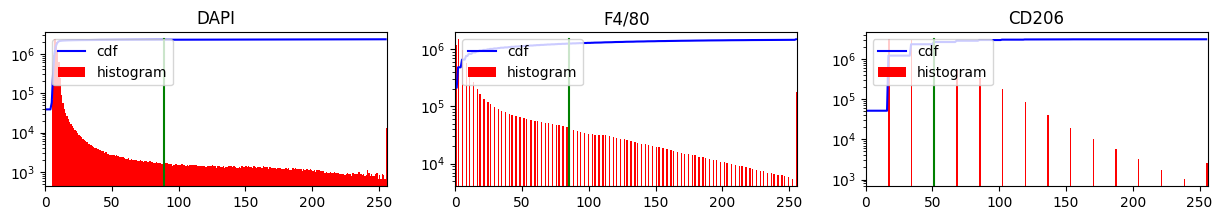

In [27]:
viewer_0 = napari.Viewer()
viewer_1 = napari.Viewer()

train_scale=[r_X,r_Y]
train_factor=[1.0,1.0]

fig, axs = plt.subplots(1,3,figsize=(15,2))

for c, c_name in enumerate(ch_marker):
    im_in=meta.get_image_data(coord_order, Z=c, C=0, S=0, T=0)
        
    im_in=(im_in/256.0).astype('uint8') 

    im_out=im_in.copy()
    print_im=im_out.copy()

    # REMOVE NOISE
    im_in=im_out.copy()
    
    if trig_remove_noise:
        im_out=filters.median(im_in)

        print_im=im_out.copy()
        
    #FILTERING
    im_in=im_out.copy()
    
    if trig_filter:
        im_out=filters.gaussian(im_in,1.0,preserve_range=True)
        
        print_im=im_out.copy()

    #HISTOGRAM TRANSFORMATION
    im_in=im_out.copy()

    if trig_transform:

        func_list=[non_proc(im_in),contr_limit(im_in,5.0,100.0),contr_limit(im_in,5.0,20.0)]
        #func_list=[non_proc(im_in),non_proc(im_in),non_proc(im_in)]

        im_out=func_list[c]
        im_trans=im_out.copy()
        print_im=im_out.copy()

    #THRESHOLDING
    im_in=im_out.copy()
    
    if trig_threshold:
        nda=sitk.GetImageFromArray(im_in)
        
        otsu_filter = sitk.OtsuThresholdImageFilter()
        otsu_filter.SetInsideValue(0)
        otsu_filter.SetOutsideValue(200)
        seg = otsu_filter.Execute(nda)
    
        val=otsu_filter.GetThreshold()
        #print(val)
        
        im_th=sitk.GetArrayFromImage(seg)

        # imax=np.max(im_in)
        # imin=np.min(im_in)

        # val=(imax-imin)/2
        
        # im_th=(im_in>val)*200.0
        
        im_out=im_th.copy()
        print_im_1=im_out.copy()

    #FILTERING
    im_in=im_out.copy()
    
    if (trig_threshold & trig_filter):
        im_out=filters.gaussian(im_in,1.0,preserve_range=True)
        im_out=im_out.astype('uint8')
        
        print_im_0=im_out.copy()

    #WATERSHED
    im_in=im_out.copy()
    #im_th=im_out.copy()

    labels=im_th.copy()
    im_labels=im_trans.copy()
    
    if trig_watershed and c_name=='DAPI':
        if trig_stardist:
            model = StarDist2D.from_pretrained('2D_versatile_fluo')
            img_te = normalize(im_labels,1.0,99.8)
            #labels, _ = model.predict_instances(img_te,prob_thresh=0.7, nms_thresh=0.2)
            labels, _ = model.predict_instances(img_te)
            #labels, _ = model.predict_instances(img_te,scale=(1.0/train_factor[0],1.0/train_factor[1],1.0/train_factor[2]),prob_thresh=0.7, nms_thresh=0.2)
            im_mask=im_th/np.max(im_th)
            im_mask=ndi.binary_erosion(im_mask,structure=np.ones((2,2))).astype(im_mask.dtype)
            im_positive=labels*(im_mask)
            list_positive=list(np.unique(im_positive))
            list_positive=list_positive[1:]
            #print(list_positive)
        else:
            distance = ndi.distance_transform_edt(im_th_filt)
            coords = peak_local_max(distance, footprint=np.ones((3,3)), labels=im_th_filt.astype('uint8'))
            mask = np.zeros(distance.shape, dtype=bool)
            mask[tuple(coords.T)] = True
            markers, _ = ndi.label(mask)
            labels = watershed(-distance, markers, mask=im_th_filt)

        cm=np.random.rand(1000,3)
        cm[0,:]=[0.0,0.0,0.0]
        colormaps_water=Colormap(cm)

        print_im_water=labels.copy()

        viewer_0.add_image(print_im_water, name=c_name, 
                        colormap=colormaps_water, blending='additive')

    globals()[c_name+'lab']=labels.copy()
    globals()[c_name+'mag']=im_labels.copy()

    #NAPARI UPLOAD
    viewer_1.add_image(print_im_1, name=c_name, 
                        colormap=ch_color[c], blending='additive')

    viewer_0.scale_bar.visible=True
    viewer_0.scale_bar.unit='um'
    viewer_1.scale_bar.visible=True
    viewer_1.scale_bar.unit='um'

    #print(np.shape(labels))
    #print(np.shape(im_mask))


    #HISTOGRAM PLOTTING
    hist,bins = np.histogram(im_trans.flatten(),256,[0,256])
    
    cdf = hist.cumsum()
    cdf_normalized = cdf* hist.max()/ cdf.max()

    axs[c].plot(cdf_normalized, color = 'b')
    axs[c].hist(im_trans.flatten(),256,[0,256], color = 'r')
    axs[c].set_xlim([0,256])
    #axs[c].set_ylim([0,100])
    axs[c].legend(('cdf','histogram'), loc = 'upper left')
    if trig_threshold:
        axs[c].plot([val,val],[0,cdf_normalized.max()],color='g')
    axs[c].set_title(c_name)
    axs[c].set_yscale('log')

## Quantification nuclei marker

In [13]:
ch_marker_2=ch_marker.copy()
ch_color_2=ch_color.copy()
ch_marker_2.remove('DAPI')
ch_color_2.remove('blue')
viewer_0 = napari.Viewer()
nuc_coord=np.zeros((int(np.max(DAPIlab))+1,2))
coord_done=False
#viewer_1 = napari.Viewer()
for c, channel in enumerate(ch_marker_2):
    ass_channel=np.zeros(DAPIlab.shape)
    globals()[channel+'pos']=[]
    globals()[channel+'coord']=np.zeros((int(np.max(DAPIlab))+1,2))
    #ass_channel_2=np.zeros(DAPIlab.shape)
    for j in range(1,int(np.max(DAPIlab))+1):
        if coord_done==False:
            x,y=np.where(DAPIlab==j)
            nuc_coord[j,0]=np.mean(x)*globals()['r_'+coord_order[0]]
            nuc_coord[j,1]=np.mean(y)*globals()['r_'+coord_order[1]]
        if np.sum(globals()[channel+'lab']*(DAPIlab==j)/np.max(globals()[channel+'lab']))>0:
            ass_channel=ass_channel+(DAPIlab==j)*1.0
            globals()[channel+'coord'][j,0]=nuc_coord[j,0]
            globals()[channel+'coord'][j,1]=nuc_coord[j,1]          
            globals()[channel+'pos'].append(j)
        #ass_channel_2=ass_channel_2+globals()[channel+'mag']*(DAPIlab==j)/np.max(globals()[channel+'mag'])
        #print(np.max(DAPIlab))
    coord_done=True

    viewer_0.add_image(ass_channel, name=channel, 
        colormap=ch_color_2[c], blending='additive')
    # viewer_1.add_image(ass_channel_2, name=channel, 
    #     colormap=colormaps[c+1], blending='additive')
        

## QUANTIFICATION

TOTAL NUCLEI 2254
PERC F4/80 96.25077674212162 %
PERC CD206 99.93475366178428 %


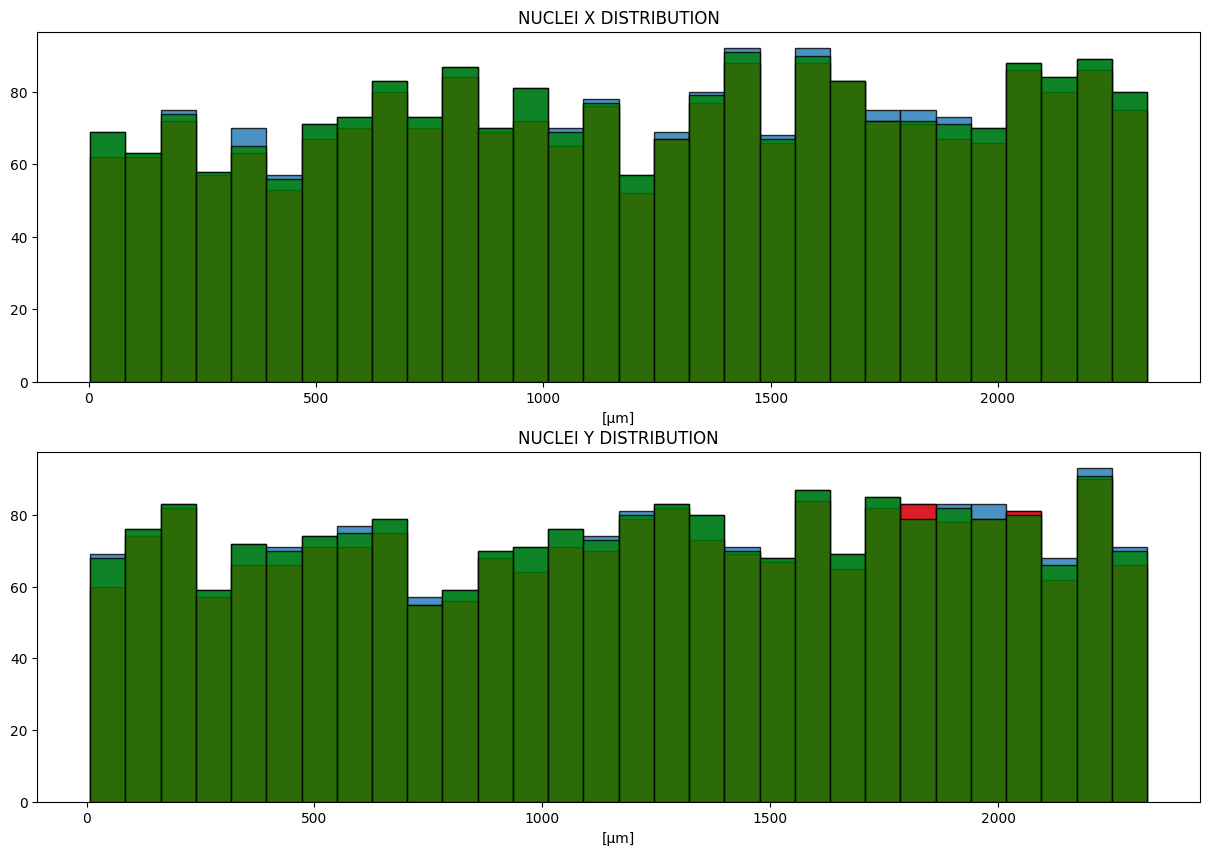

In [14]:
print('TOTAL NUCLEI ' + str(np.max(DAPIlab)+1))
for c, channel in enumerate(ch_marker_2):
    print('PERC ' + channel + ' ' + str(100.0 * len(globals()[channel + 'pos'])/np.max(DAPIlab)+1) + ' %')
fig, axs = plt.subplots(2,1,figsize=(15,10))
axs[0].hist(nuc_coord[1:,coord_order.find('X')],bins=30,range=(min(nuc_coord[1:,coord_order.find('X')]),max(nuc_coord[1:,coord_order.find('X')])),alpha=0.8,edgecolor='black')
for c, channel in enumerate(ch_marker_2):
    axs[0].hist(globals()[channel+'coord'][globals()[channel + 'pos'],coord_order.find('X')],bins=30,range=(min(nuc_coord[1:,coord_order.find('X')]),max(nuc_coord[1:,coord_order.find('X')])),alpha=0.8,color=ch_color_2[c],edgecolor='black')
axs[0].set_title('NUCLEI X DISTRIBUTION')
axs[0].set_xlabel('[μm]')
axs[1].hist(nuc_coord[1:,coord_order.find('Y')],bins=30,range=(min(nuc_coord[1:,coord_order.find('Y')]),max(nuc_coord[1:,coord_order.find('Y')])),alpha=0.8,edgecolor='black')
for c, channel in enumerate(ch_marker_2):
    axs[1].hist(globals()[channel+'coord'][globals()[channel + 'pos'],coord_order.find('Y')],bins=30,range=(min(nuc_coord[1:,coord_order.find('Y')]),max(nuc_coord[1:,coord_order.find('Y')])),alpha=0.8,color=ch_color_2[c],edgecolor='black')
axs[1].set_title('NUCLEI Y DISTRIBUTION')
axs[1].set_xlabel('[μm]')
plt.show()

### Create a complete report XSL

In [15]:
workbook=xlsxwriter.Workbook(Path(tiff_file).stem+'.xlsx')

## FORMATS
header=workbook.add_format({'bg_color':'blue','bold':True})
#header.set_bg_color('yellow')
floats=workbook.add_format({'num_format':'0.00'})
percs=workbook.add_format({'num_format':'0.00%'})
text=workbook.add_format({'num_format':'@'})

## MACROPHAGES TAB
worksheet_cell=workbook.add_worksheet('Macrophages')

#HEADER
worksheet_cell.write_row('A1:C1',['#ID','X','Y'],header)
for c, channel in enumerate(ch_marker_2):
    header=workbook.add_format({'bg_color':ch_color_2[c],'bold':True})
    #header.set_bg_color(ch_color_2[c])
    worksheet_cell.write(0,3+c,channel,header)
    #worksheet_cell.write(0,4+c*2,channel+' % vol',header)
    
#CONTENT
for row in range(1,int(np.max(DAPIlab))+1):
    worksheet_cell.write(row,0,row)
    worksheet_cell.write(row,1,nuc_coord[row][coord_order.find('X')],floats)
    worksheet_cell.write(row,2,nuc_coord[row][coord_order.find('Y')],floats)
    for c, channel in enumerate(ch_marker_2):
        ass_channel=(globals()[channel+'lab']*(DAPIlab==row)/np.max(globals()[channel+'lab']))>0
        worksheet_cell.write(row,3+c,(np.sum(ass_channel)>0).astype('bool'),text)

## RECAP TAB
worksheet_recap=workbook.add_worksheet('Recap')

#CONTENT
worksheet_recap.write_row('A1:A2',['Tot. cells',str(np.max(DAPIlab)+1)])
for c, channel in enumerate(ch_marker_2):
    worksheet_recap.write(c+1,0,'PERC ' + channel,text)
    worksheet_recap.write(c+1,1,len(globals()[channel + 'pos'])/(np.max(DAPIlab)+1),percs)    

workbook.close()